## DOCSIS

In [ ]:
using Pkg
Pkg.add("Gadfly")
Pkg.add("FFTW")
Pkg.add("Distributions")
Pkg.add("DataFrames")

using Gadfly
using FFTW
using Distributions
using DataFrames
using Random
using LinearAlgebra

ns = 1/1_000_000_000
mV = 1/1_000
MHz = 1_000_000

totalTime = 999ns
samples = 999
samplingInterval = totalTime/samples

amplitude = 500mV
carrierFrequency = 50MHz
carrierInitialPhase = 0 # π
symbolInterval = 200ns
symbols2 = [1, 0, 1, 1, 0]


time = (0:samples-1).*samplingInterval
symbols2InTime = map(t -> symbols2[trunc(Int, t/symbolInterval) + 1], time)

;

In [ ]:
a=7
π # to jest mała grecka literka pi. Robi to samo co w matematyce.
5a # 35 # to jest mnożenie # oczywiscie 5 * a też działa
2^3 # to jest potegowanie (nie xor!)
v= [1, 2, 3] # to jest Vector (pionowy), znany też jako Array 1-wymiarowy
v[2] # ==2 # tablice (w tym wektory i macierze) indeksujemy od 1
[1; 2; 3] # to też jest Vector (pionowy)
[1 2 3] # to jest "wektor" (poziomy), czyli tak naprawdę Matrix, zany też jako Array 2-wymiarowy,  z pierwszym wymiarem = 1
[1 2; 3 4] # to jest macierz 2x2 # uwaga Julia ma prawdziwe tablice n-wymiarowe. Nie tablice referencji do tablic jak JVM.
1:10 # to jest zakres od 1 do 10
v.+7 # to jest "element-wide plus". Operacja dodawania 7 jest wykonywana na każdym elemencie wektora v
@. v*2+7 # zamiast ręcznie kropkować operatory/funkcje, można użyć makra @., pod warunkiem ze naszą intencją jest żeby zakropkować wszystko na maksa
(v.*2).+7 # to jest to samo co linijka wyżej

[i*i for i in 1:3] # ==[1, 4, 9] # to jest for-comprehension

# to jest funkcja
squared(x) = x*x

# to też jest funkcja
function cubed(x::Number)::Number
    x^3
end

# to jest zmienna zainicjowana lambdą, czyli prawie niczym się nie różni od funkcji
plusOne = x -> x+1

norm([2, 3, 4]) # to jest "norma" czyli "długość" wektora. Liczymy to po kartezjańsku, albo jak niektóry wolą "z pitagorasa" sqrt(2^2 + 3^2 + 4^2)


## Let's build a modem!

Our goal is to send data in both directions over a distance of kilometers.
We want to send as much data as possible for as little money as possible.

Oh, by the way "modem" stands for "modulator & demodulator".
"modulation" is the act of putting information into a signal (by varying some of it's properties).
"demodulation" is about extracting that information

Theoretailly we can use any physical phenomena to transfer information. (sound waves, radio wave, voltage, light, carrier pigeons). We'll focus on voltages and electro-magnetic waves in radio frequencies.

### non-return-to-zero level (NRZL) - as simple as it gets
We choose a symbol rate that is how many symbols we wil send per unit of time
Each symbol will carry 1 bit.
We send the data though a cable by applying a voltage between the data line and the ground line.
We encode 1 as a high voltage (500mV in the example) and 0 as a low voltage (0mV in the example).
The reciever reads anything above 250mV as 1 and anything below 250mV as 0.
(The voltages are actually very low for this kind of communication, but I wanted to use the 500mV thoughout all examples, to avoid confusion)
We add a second signal, the clock signal, this way the receiver knows when to sample the voltage of the data symbol (on a raising edge of the clock signal)

This is how SPI / I2S works. It works well for shot ranges (50cm) and moderate bitrates (20Mbit/s).

In [ ]:
modulated = symbols2InTime*500mV
clock = @. convert(Int, time%symbolInterval > symbolInterval/2)*500mV

set_default_plot_size(1000px, 800px*2/3)
vstack(
    plot(
        layer(x = time./ns, y = modulated./mV, Geom.line),
        layer(x = map(i -> (i-0.5)*symbolInterval, (1:5))/ns, y = fill(600, 5), label = map(s -> string(s), symbols2), Geom.label),
        Guide.title("modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]"),
    ),
    plot(x = time./ns, y = clock./mV, Geom.line, Guide.title("clock"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### Clock recovery

In the example above we need 3 cables:
* data signal
* clock signal
* ground

Clock is a problem because:
* additional line costs a lot at long ranges
* it's twice as fast as data signal

We can design the system to "recover" clock from the data signal. We just need to make sure that there's never a long sequence of the same symbol. We do it by some mix of:
- scrambling - XORing the data with a pseudo random sequence
- line coding like 8b/10b encoding (10b has 1024 values. If we want to send 256 values using 10b, then we can choose only those that have a nice mix of 0s and 1s)

### Problems withthis approach
* very sensitive to interference
* simple voltage level recognition stops working when the voltage drops
* shape of the wave degrades in long cables
* has a DC component (average voltage level != 0)
* how do we do upstream?
* ...
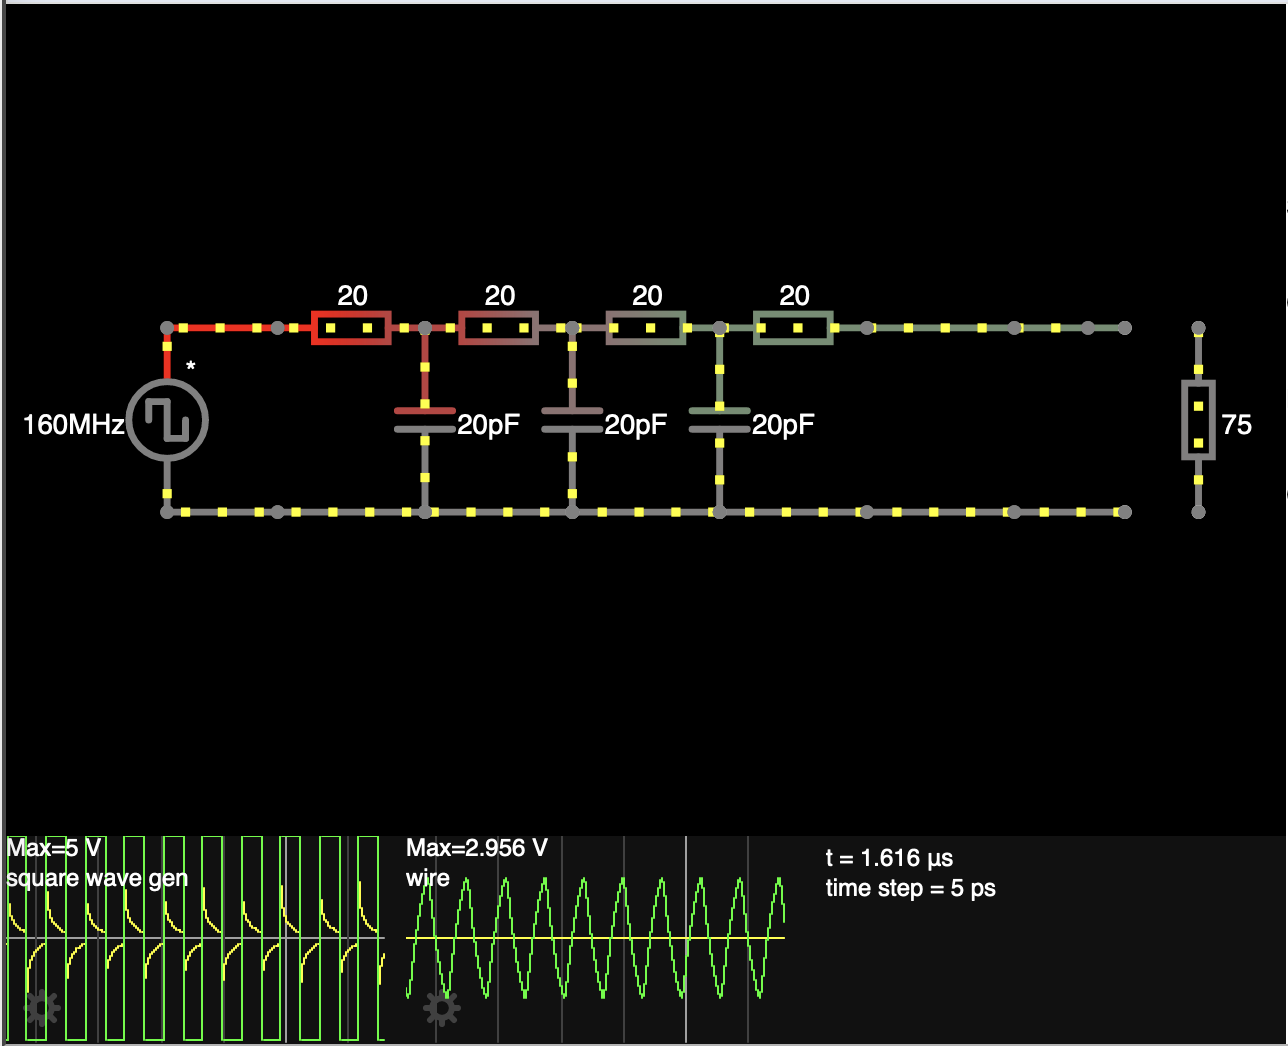

In [ ]:
frequency = 10MHz
interval = 1/frequency
signal = @. convert(Int, time%interval > interval/2)*500mV

set_default_plot_size(1000px, 800px*1/3)
plot(
    layer(x = time./ns, y = signal./mV, Geom.line), Guide.title("square wave"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]"),
)

In [ ]:
function plotFFT(signal) 
    shifted_k = fftshift(fftfreq(samples, 1/samplingInterval))
    shifted_fft = fftshift(fft(signal))
    set_default_plot_size(1000px, 800px)
    vstack(
        plot(x = shifted_k/MHz, y = abs.(shifted_fft), Geom.hair, Guide.title("Frequency spectrum (Fourier transform amplitudes)"), Guide.xlabel("frequency[MHz]"), Guide.ylabel("V[mV]")),
        plot(x = shifted_k/MHz, y = angle.(shifted_fft), Geom.hair, Guide.title("Frequency spectrum (Fourier transform phases)"), Guide.xlabel("frequency[MHz]"), Guide.ylabel("phase[rad]")),
        plot(x = shifted_k/MHz, y = abs.(shifted_fft), Geom.point, Geom.hair, Coord.cartesian(xmin=-60, xmax=60, ymin=0, ymax=500), Guide.title("Frequency spectrum (Fourier transfrom amplitudes zoomed in)"), Guide.xlabel("frequency[MHz]"), Guide.ylabel("V[mV]")),
    )
end

signal = @. convert(Int, time%interval > interval/2)*500mV
plotFFT(signal)

https://en.wikipedia.org/wiki/Square_wave#/media/File:Fourier_series_for_square_wave.gif

In [ ]:
signal = @. amplitude * cos(2π * 10MHz * time + carrierInitialPhase)

set_default_plot_size(1000px, 800px*1/3)
plot(
    layer(x = time./ns, y = signal./mV, Geom.line), Guide.title("cosine wave"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]"),
)

In [ ]:
plotFFT(signal)

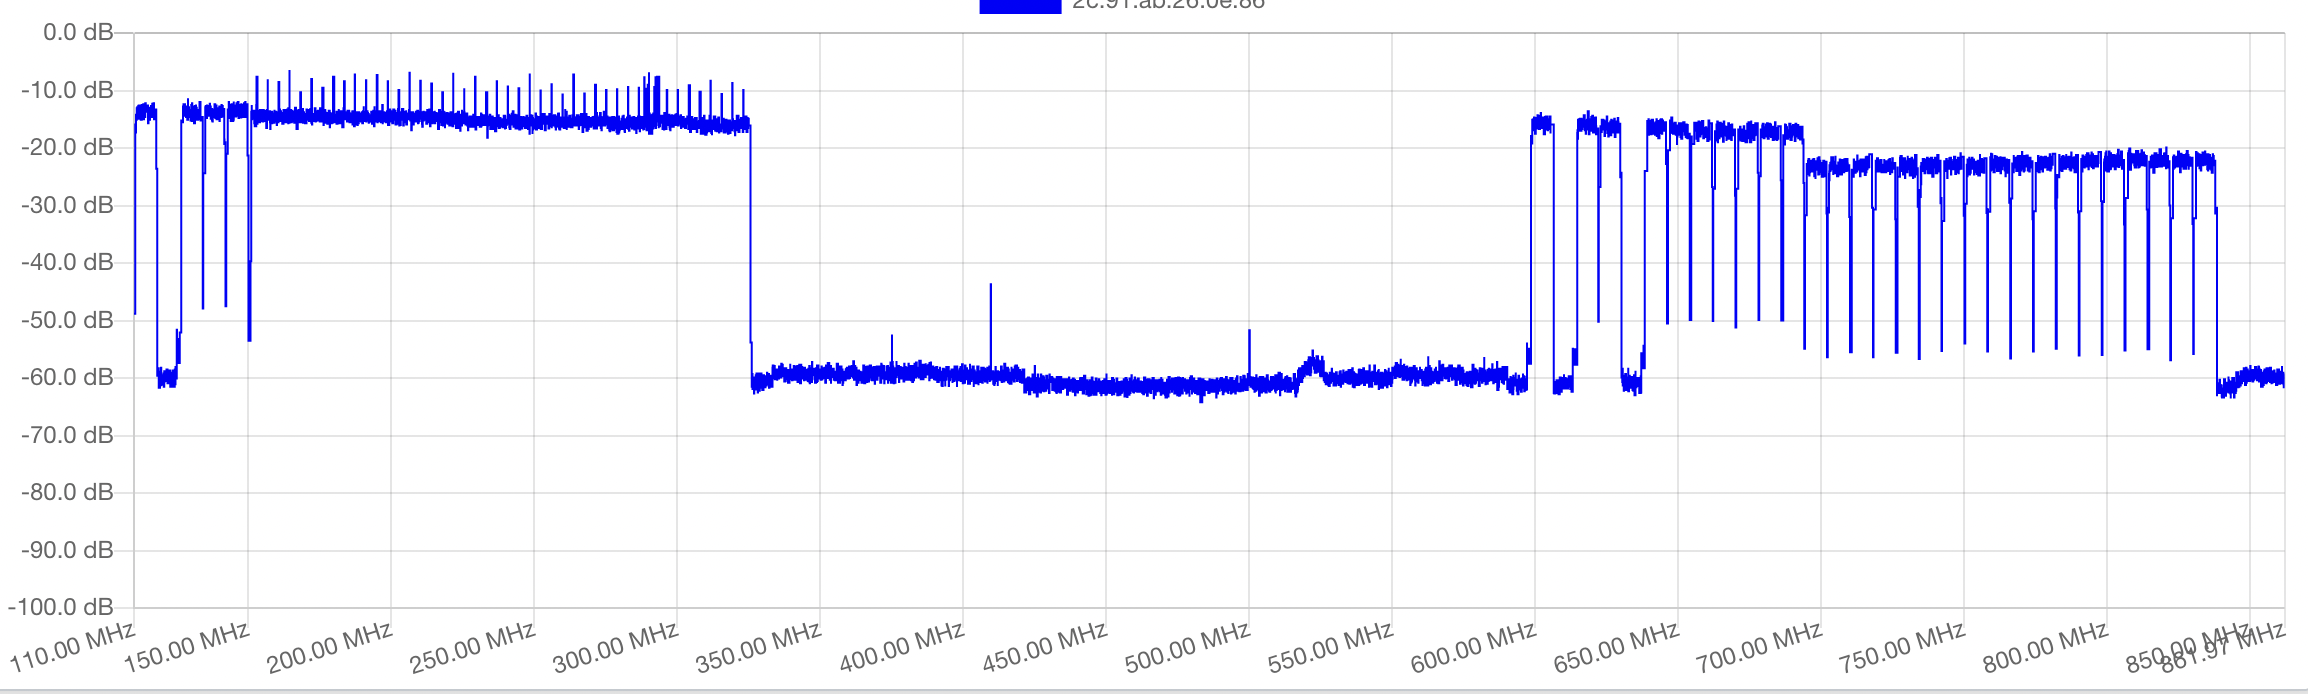

### Modulating sine wave

In [ ]:
carrier = @. amplitude * cos(2π * carrierFrequency * time + carrierInitialPhase)

# color=[colorant"red"]

set_default_plot_size(1000px, 800px/3)
vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("Carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### Amplitude modulation (AM)

In [ ]:
modulationSignal = @. cos(time * 2π * 2MHz)
modulatedAM = @. modulationSignal * cos(time * 2π * carrierFrequency)
# Beware 90% of code examples in the internet are in fact Phase Modulation
m = cumsum(modulationSignal)
modulatedFM = @. amplitude * cos(time * 2π * carrierFrequency + 0.2 * m)
pmCarrier = @. amplitude * cos(time * 2π * carrierFrequency/5)
modulatedPM = @. amplitude * cos(time * 2π * carrierFrequency/5 + π * modulationSignal)

set_default_plot_size(1000px, 800px)
vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("Carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal.*1000, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),
    plot(x = time./ns, y = modulatedAM./mV, Geom.line, Guide.title("AM modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### Frequency Modulation (FM)

In [ ]:
modulationSignal = @. cos(time * 2π * 2MHz)
modulatedAM = @. modulationSignal * cos(time * 2π * carrierFrequency)
# Beware 90% of code examples in the internet are in fact Phase Modulation
m = cumsum(modulationSignal)
modulatedFM = @. amplitude * cos(time * 2π * carrierFrequency + 0.2 * m)
pmCarrier = @. amplitude * cos(time * 2π * carrierFrequency/5)
modulatedPM = @. amplitude * cos(time * 2π * carrierFrequency/5 + π * modulationSignal)

set_default_plot_size(1000px, 800px)
vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("Carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal.*1000, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),
    plot(x = time./ns, y = modulatedFM./mV, Geom.line, Guide.title("FM modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### Phase Modulation (PM)

In [ ]:
modulationSignal = @. cos(time * 2π * 2MHz)
modulatedAM = @. modulationSignal * cos(time * 2π * carrierFrequency)
# Beware 90% of code examples in the internet are in fact Phase Modulation
m = cumsum(modulationSignal)
modulatedFM = @. amplitude * cos(time * 2π * carrierFrequency + 0.2 * m)
pmCarrierFrequency = carrierFrequency/5
pmCarrier = @. amplitude * cos(time * 2π * pmCarrierFrequency)
modulatedPM = @. amplitude * cos(time * 2π * pmCarrierFrequency + π * modulationSignal)

set_default_plot_size(1000px, 800px)
vstack(
    plot(x = time./ns, y = pmCarrier./mV, Geom.line, Guide.title("Carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal.*1000, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),   
    plot(x = time./ns, y = modulatedPM./mV, Geom.line, Guide.title("PM modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

In [ ]:
set_default_plot_size(1000px, 800px)

### Amplitude-shift keying (ASK)

In [ ]:
modulationSignal = symbols2InTime
modulated = @. modulationSignal * cos(time * 2π * carrierFrequency)

vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),
    plot(x = time./ns, y = modulated./mV, Geom.line, Guide.title("modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### Phase-shift keying (PSK)

In [ ]:
modulationSignal = symbols2InTime
modulated = @. cos(time * 2π * carrierFrequency + modulationSignal * π)

vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),
    plot(x = time./ns, y = modulated./mV, Geom.line, Guide.title("modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
)

### More bits per symbol? (Modulation order)

In [ ]:
symbols4 = [3, 0, 2, 1, 2]
symbols4InTime = map(t -> symbols4[trunc(Int, t/symbolInterval) + 1]/3, time)

modulationSignal = symbols4InTime
modulated = @. modulationSignal * cos(time * 2π * carrierFrequency)

vstack(
    plot(x = time./ns, y = carrier./mV, Geom.line, Guide.title("carrier"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = time./ns, y = modulationSignal, Geom.line, Guide.title("modulationSignal"), Guide.xlabel("t[ns]"), Guide.ylabel("data")),
    plot(
        layer(x = time./ns, y = modulated./mV, Geom.line),
        layer(x = map(i -> (i-0.5)*symbolInterval, (1:5))/ns, y = fill(1500, 5), label = map(s -> string(s), symbols4), Geom.label),
        Guide.title("modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]"),
    ),
)

### Modulating Amplitude and Angle

carrier = @. amplitude * cos(2π * carrierFrequency * time + carrierInitialPhase)

We can simultainously modulate the amplitude and one of the angle parameters (either frequency or phase)
In digital modulation will typically choose phase for ease of implementation.
We can present the symbols as a conselation diagram

In [ ]:
askN(n) = hcat((0:n-1).*(1/(n-1)), (1:n).*(0))
pskN(n) = hcat(cos.((1:n).*(2π/n)), sin.((1:n).*(2π/n)))
pskNOffset(n) = hcat(cos.(((1:n).+0.5).*(2π/n)), sin.(((1:n).+0.5).*(2π/n)))
qamNsquared(n) = vcat([[(i-1)/(n-1)*2-1 (j-1)/(n-1)*2-1] for i=1:n, j=1:n]...)

function plotConstelation(c, title)
    set_default_plot_size(800px, 850px)
    plot(x = c[:, 1]',  y = c[:, 2]',  Geom.point, 
        Theme(point_size = 10px), Coord.cartesian(xmin=-1.5, xmax=1.5, ymin=-1.5, ymax=1.5),
        Guide.title(title), Guide.xlabel("I (in-phase) (cos)"), Guide.ylabel("Q (quadrature) (sin)"))
end
;

In [ ]:
# BEWARE Wikipedia QAM16 illustration is wrong!
title = "Constelation diagram"
c = qamNsquared(4)
plot(
    layer(x = c[:, 1]',  y = c[:, 2]',  Geom.point, Theme(point_size = 10px)),
    layer(x = [0, 1/3], y = [0, 1], Geom.line, color=[colorant"red"]),
    layer(x = [1/3/2], y = [1/2], label= ["Amplitude=1.054"], Geom.label),
    layer(x = [1/6], y = [1/6], label= ["phase=π/3"], Geom.label),
    layer(x = [0, 1/3], y = [0, 0], Geom.line, color=[colorant"red"]),
    layer(x = [1/3], y = [0], label= ["I=1/3"], Geom.label),
    layer(x = [0, 0], y = [0, 1], Geom.line, color=[colorant"red"]),
    layer(x = [0], y = [2/3], label= ["Q=1"], Geom.label),
    Coord.cartesian(xmin=-1.5, xmax=1.5, ymin=-1.5, ymax=1.5),
    Guide.title(title), Guide.xlabel("I (in-phase) (cos)"), Guide.ylabel("Q (quadrature) (sin)"))

In [ ]:
plotConstelation(askN(2), "BASK")

In [ ]:
plotConstelation(pskN(2), "BPSK")

In [ ]:
plotConstelation(pskN(4), "QPSK")

In [ ]:
plotConstelation(pskN(8), "8-PSK")

In [ ]:
plotConstelation(pskN(16), "16-PSK")

In [ ]:
plotConstelation(vcat([pskN(12), pskNOffset(4).*0.5]...), "16-APSK")

In [ ]:
https://en.wikipedia.org/wiki/Phase_(waves)#/media/File:Phase_shifter_using_IQ_modulator.gif

In [ ]:
plotConstelation(qamNsquared(4), "16-QAM")

### Measureing signal quality

dB - decibel

deci = 10

B = log10(x)

dB means either that that's a ratio of two things so there are no units, or that we're referencing power to 1W

* dB - 10*log10(P1/P2)
* dB - 10*log10(P/1W)

* dBm - referencing to mW

Things get strange as we get to V. Because V is a unit of Voltage, but we use it to represent signal power.
In physics P = U*I or P = U^2/R. In telecommunications we assume R = 1 Ohm and go with P = U^2.

* dBmV - referecing to 1mV
* dBuV - referecing to 1uV

10*log10(U^2) = 20*log10(U)

20*log10(U[mV]) = 20*log10(1000*U[uV]) = 20*(log10(1000) + log10(U[uV])) = 60+20*log10(U[uV])

* dBc - 10*log10(P/P_carrier)

MER - Modulation Error Ratio = @. 10*log10(rms(symbolPower)/rms(errorPower)) [dB]
SNR - Signal-to-Noise Ratio =  @. 10*log10(signalPower / noisePower)
(there's other stuff like CNR, CNIR, ..., let's skip that)

In [ ]:
using LinearAlgebra

function plotConstelationSmall(c, title)::Plot
    set_default_plot_size(800px, 850px)
    plot(x = c[:, 1]',  y = c[:, 2]',  Geom.point, 
        Theme(point_size = 3px), Coord.cartesian(xmin=-1.5, xmax=1.5, ymin=-1.5, ymax=1.5),
        Guide.title(title), Guide.xlabel("I (in-phase) (cos)"), Guide.ylabel("Q (quadrature) (sin)"))
end

power(s::Matrix{Float64}):: Vector{Float64} = norm.(eachrow(s)).^2
rms(s::Vector{Float64}):: Float64 = norm(s)/sqrt(length(s))
rmsPower = rms ∘ power

function qamNsquaredWithNoise(n::Int, mer::Number)::Matrix{Float64}
    samplesPerSymbol = 50
    signal = qamNsquared(n)
    sigma = sqrt(rmsPower(qamNsquared(4)) / (10^(mer/10)*2*sqrt(2)))
    noise = [rand(Normal(0.0, sigma), size(signal)) for i=1:samplesPerSymbol]
    actualMER = 10*log10(rmsPower(signal)/rmsPower(vcat(noise...)))
    println("MER=$(actualMER)")
    vcat([signal.+noise[i] for i=1:samplesPerSymbol]...)
end

function plotQAMNsquaredWithNoise(n::Int, mer::Number)::Plot
    plotConstelationSmall(qamNsquaredWithNoise(n, mer), "$(n*n)-QAM with MER=$(mer)")
end
;

# println(10*log10(rmsPower(qamNsquared(4))/(2*sqrt(2)*sss^2)))
# println(10*log10(rmsPower(qamNsquared(4))/rmsPower(rand(Normal(0.0, sss), (100000, 2)))))
# plotQAMNsquaredWithNoise(4, 18.0)

In [ ]:
plotQAMNsquaredWithNoise(4, 18)

In [ ]:
plotQAMNsquaredWithNoise(4, 12)

In [ ]:
plotQAMNsquaredWithNoise(4, 24)

In [ ]:
plotQAMNsquaredWithNoise(8, 24)

### Forward error correction (FEC)
* We can add some redundancy to the data, in such a way that we can later use it to detect and/or correct transmision error
* Reed-Solomon (RS) code in DOCSIS 3.0
* Low-Density Parity Check (LDPC) in DOCSIS 3.1

It worka simliirly to how you can read text I wrcte despite typis.

Although FEC adds overhead, it actually pays of because we can tolarete some number of errors, so we can push for higher modulations with the same SNR/MER

Some number of correctable codeword errors is actually good. It means we're pushing as much data though the channel as we can.

Example configuration:
Upstreams on LAB CMTS send 95 data bytes + 24 redundancy bytes = 119 bytes RS codeword that can tollerate up to 12 damaged bytes

### Shannon–Hartley theorem
There is a theoretical limit of how much information can be sent though a channel. It's defined by Shannon–Hartley theorem and is often called Shannon limit. It assumes Additive White Gaussian Noise (AWGN), so practicall limit may be a bit different. Different designs are often compared to the Shannon limit (they're trying to get as closs as possible given current technology and financial constraints).

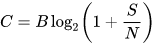

### Frequency spectrum of QAM

EuroDOCIS Single Carrier channel
Channel bandwidth = 8MHz
symbol rate = 6.952 Msym/s

Bandwidth is propotional to symbol rate
For QAM theoretical optimum is bandwidth = symbolrate
Theoretical optimum is bandwidth = symbolrate/2


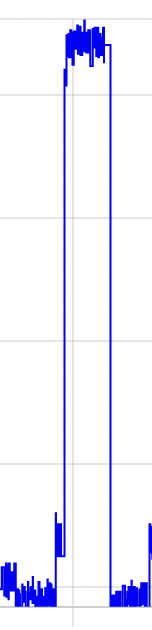

In [ ]:
using Random
symbolsWithNoise = Random.shuffle(qamNsquaredWithNoise(4, 18))
carrierFrequency = 100MHz
symbolInterval = 1/20MHz
samples2 = size(symbolsWithNoise, 1) * symbolInterval/samplingInterval / 8 # The whole symbolsWithNoiseis too much so we divide the sie
time = (1:samples2).*samplingInterval
signal = @. (
    (symbolsWithNoise[trunc(Int, time/symbolInterval) + 1, 1] * amplitude * cos(time * 2π * carrierFrequency)) + 
    (symbolsWithNoise[trunc(Int, time/symbolInterval) + 1, 2] * amplitude * sin(time * 2π * carrierFrequency))
    )

println(amplitude)
println(symbolsWithNoise[1, 2])

shifted_k = fftshift(fftfreq(length(signal), 1/samplingInterval))
shifted_fft = fftshift(fft(signal))
println(shifted_fft[750:800])
set_default_plot_size(1000px, 800px)
vstack(
    plot(x = time./ns, y = signal./mV, Geom.line, Guide.title("modulated"), Guide.xlabel("t[ns]"), Guide.ylabel("V[mV]")),
    plot(x = shifted_k/MHz, y = log10.(abs.(shifted_fft)).*10, Geom.hair, Coord.cartesian(xmin=0, xmax=200, ymin=-10, ymax=30), Guide.title("Frequency spectrum (Fourier transfrom amplitudes zoomed in)"), Guide.xlabel("frequency[MHz]"), Guide.ylabel("[dBV???]")),
    plot(x = shifted_k/MHz, y = angle.(shifted_fft), Geom.hair, Coord.cartesian(xmin=0, xmax=200, ymin=-π, ymax=π), Guide.title("Frequency spectrum (Fourier transform phases)"), Guide.xlabel("frequency[MHz]"), Guide.ylabel("phase[rad]")),
)

### How to get a high bitrate
* Use FEC and push the channel to the limits
* double bandwidth -> double symbolrate -> double bitrate
* increase signal power by 3dB -> increase SNR/MER by 3dB -> use higher modulation (1 more bits per symbol)
* decrease noise/interference by 3dB -> increase SNR/MER by 3dB -> use higher modulation (1 more bits per symbol)
* Advanced hint: Real channels have interference that is not AWGN

### Other (than AWGN) interferences (just some types)
* long-term, wide-band, high-power - search & destroy ;)
* short-term, wide-band, high-power - some symbols are damaged, but other symbols in the codeword should be fine, so we can correct. We can further improve, by interleaving codewords (this way the damage is spread across multiple codewords)
* long-term, narrow-band, high-power - OFDM can deal with it by adjusting modulation on subcarriers or using exclusion bands
* long-term, wide-band, low-power - well, it's just noise. Get better cables or something.

### OK, but how do we do upstream?

Sending more than one signal though single medium is called multiplexing.
We differentiate the signals by some property:
* Frequency-Division Multiplexing (FDM)
* Time-Division Multiplexing
* Space-Division Multiplexing (SDM, but you know it as MIMO)
* Polarisation-Division Multiplexing (PDM) (laser / optical)
* Ortogonal-Frequency-Division Multiplexing (OFDM) (not realy)

If we use it to let multiple devices use one medium, then instead of "multiplexing" we say "multiple access"
* Frequency division multiple access (FDMA)
* Time-division multiple access (TDMA)
* ...
* Code-division multiple access (CDMA)
* Ortogonal-Frequency-Division Multiple Access (OFDMA) (kinda)

In DOCSIS we do 
* FDM to have upstreams and downstreams
* We do (A)TDMA / CDMA to let multiple modems use one sc upstream
* We do TaFDMA to let multiple modems use one OFDMA upstream at the same time
< 65MHz Upstream
> 85MHz Downstream


In [ ]:
channel(center::Float64, width::Float64, color, height=1.0) = DataFrame(x0 = center-width/2+0.4, y0=0, x1=center+width/2-0.4, y1=height, color=color, )
scDsChannel(center::Float64) = channel(center, 8.0, colorant"green")
sc64MHzUsChannel(center::Float64) = channel(center, 6.4, colorant"orange")
ofdmChannel(start::Float64, endd::Float64) = channel((start+endd)/2, endd-start, colorant"blue")
ofdmaChannel(start::Float64, endd::Float64) = channel((start+endd)/2, endd-start, colorant"violet", 1.1)

channels = vcat(
    ofdmaChannel(29.3, 65.3),
    sc64MHzUsChannel(30.8), sc64MHzUsChannel(37.2 ), sc64MHzUsChannel(44.6), sc64MHzUsChannel(51.0),
    scDsChannel(114.0), scDsChannel(130.0), scDsChannel(138.0), scDsChannel(146.0),
    ofdmChannel(151.0, 325.0),
    [scDsChannel(cf) for cf=602.0:8.0:858.0]...
)

set_default_plot_size(1000px, 250px)
plot(
    layer(channels, xmin=:x0, ymin=:y0, xmax=:x1, ymax=:y1, color=:color, alpha=[0.7], Geom.rect,),
    layer(x = [65, 65], y=[0, 1.5], color=[colorant"black", colorant"black"], Geom.line),
    layer(x = [65-35], y=[1.5], label=["65MHz"],  Geom.label),
    layer(x = [85, 85], y=[0, 1.5], color=[colorant"black", colorant"black"], Geom.line,),
    layer(x = [85+10], y=[1.5], label=["85MHz"], Geom.label),
    Coord.cartesian(xmin=0, xmax=862, ymin=0, ymax=1.5),
    Guide.title("DOCSIS Frequency division multiplex"), Guide.xlabel("frequency [MHz]"), Guide.ylabel(""),
)


In [ ]:
channels = vcat(
    ofdmaChannel(29.3, 65.3),
    sc64MHzUsChannel(30.8), sc64MHzUsChannel(37.2 ), sc64MHzUsChannel(44.6), sc64MHzUsChannel(51.0),
    scDsChannel(114.0), scDsChannel(130.0), scDsChannel(138.0), scDsChannel(146.0),
    ofdmChannel(151.0, 325.0),
    [scDsChannel(cf) for cf=338.0:8.0:458.0]...
)

set_default_plot_size(1000px, 250px)
plot(
    layer(channels, xmin=:x0, ymin=:y0, xmax=:x1, ymax=:y1, color=:color, alpha=[0.7], Geom.rect,),
    layer(x = [65, 65], y=[0, 1.5], color=[colorant"black", colorant"black"], Geom.line),
    layer(x = [65-20], y=[1.5], label=["65MHz"],  Geom.label),
    layer(x = [85, 85], y=[0, 1.5], color=[colorant"black", colorant"black"], Geom.line,),
    layer(x = [85+5], y=[1.5], label=["85MHz"], Geom.label),
    Coord.cartesian(xmin=0, xmax=466, ymin=0, ymax=1.5),
    Guide.title("DOCSIS Frequency division multiplex (simplified)"), Guide.xlabel("frequency [MHz]"), Guide.ylabel(""),
)

### OFDM and OFDMA
Instead of QAM modulating one carrier at high symbol rate resulting in 8MHz channel. 
Let's QAM modulate lot's of (4K / 8K) small sub-carriers (50kHz / 25kHz). 
Except we don't really want to manufacture 8000 modulators and demodulators.

Rember: We can can convert signalSamples <-> fourier transform.
Instaed of modulating the signal. 
We design caculate the fourier transform we want to achieve, and then convert it back to signalSamples, and then transmitter generates signal according to those samples.
Receiver samples the signal does, FFT and decodes the samples.

### OFDMA
Works similarly to OFDM. Additinally 
- we may let multiple modems transmitt at the same time but on different subcarriers
- because there's no bandwiths for OFDMA, we let the OFDM share band with SC upstreams, and we do TDMA btween the two.
                
                
### Why?
* low sample rate means high rubustnest againts inter-symbol-interference (multipath propagation, microreflections)
* before we wher doing 6.9MSample in 8MHz. Now we're doing 50kSample in 50kHz (less waste, still half of theoretical optimum)
* we can set different parameters per subcarrier to addjust to narrow-band interference
* now need of input filtering
* still simple to modulate / demodulate

Additinally:
DOCSIS 3.1 brings: 
* higher QAM modulations (up to 16384-QAM for OFDM, and up to 4096-QAM for OFDMA)
* profiles so modems with good signal use high modulations and modems with poor signal use low

PLC - Physical layer Link Channel
A set of special subcarriers transmitting information about the channel 
(treated as band 0 for the purpose of power measurment reporting)
frequencies, locations of pilots, excluded subcarriers, modulation, cyclic prefix, etc...

NCP - Next codeword pointer
Which codewards, in which profiles, on which subcarriers

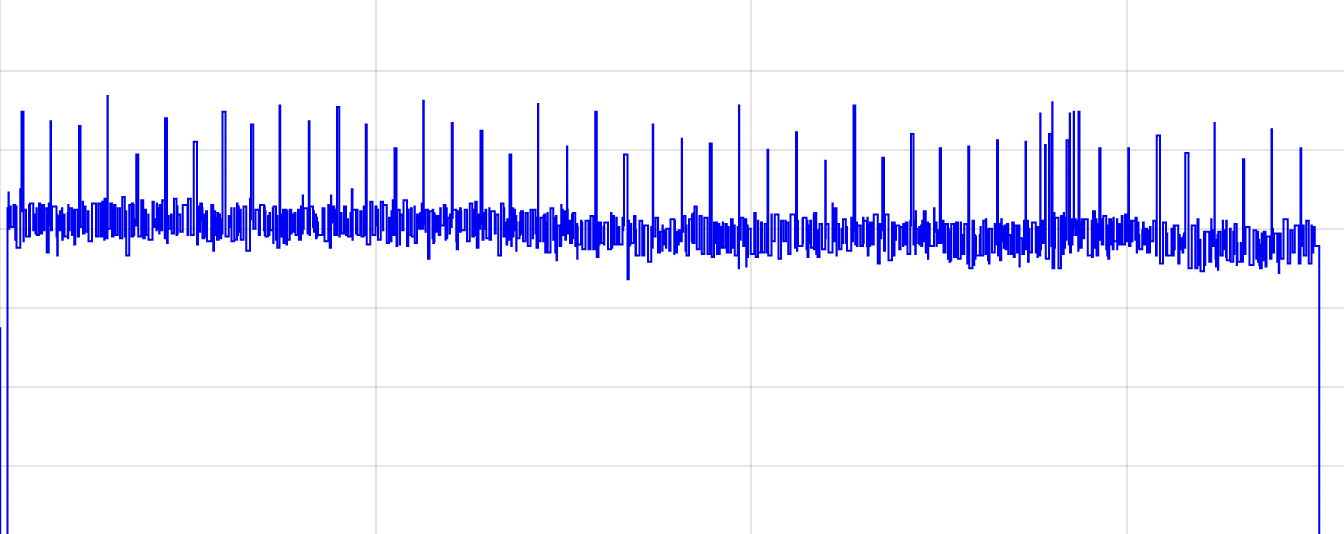

### Basics of Channel configuration

#### SC-QAM Downstreams
* Each downstream has a fixed configuration. 
* Typically downstreams on lower frequencies use 256-QAM and downstreams on higher frequencies use 64-QAM (generally attenuation increases with frequency, so the higher frequency channels have worse signal quality)

#### OFDM Downstreams
* We choose either 50kHz (4k FFT) or 25kHz (8k FFT) subcarriers
* There is a guarband at the beginning and the end of OFDM encompased spectrum
* subcarriers can be configured as pilots, PLC, exclusion bands, or data (potentially with different modulations, although the prectice in VFKD is to use one )
* There are 4 profiles (1-4 in SNMP/MEPS, A-D in more official texts). They can be configured with differen modualtions so that each modem can use the higest modualtion that works for it. A is the most robust profile (lowest modualtion)

#### SC-QAM Upstreams

##### Interval Usage Codes

* CMTS sends MAP (Upstream Bandwidth Allocation) messages (though DS channels) to inform modems of the planned burst intervals on upstream channels. 
* These burst intervals may be of different kinds. And that kind is indicated by Interval Usage Code (IUC).
* IUCs can have different configuration (burst profile) in terms of modulattion, FEC, and other technical parameters. That is communicated in Upstream Channel Descriptor (UCD) Typically:
    * Data transfer IUCs are configured for maximum thoughput (high modulation, moderate FEC)
    * Other "technical" IUCs are configured for robustness.
    * One SC-US may be configured (or reconfigure itself automatically) with more robust data transfer, as a fallback for modems with problems
   
##### IUCs in SC-QAM
         request(1),
         requestData(2),
         initialRanging(3),
         periodicRanging(4),
         shortData(5),
         longData(6),
         advPhyShortData(9),
         advPhyLongData(10),
         ugs(11)
         
#### OFDMA Upstreams
* The "techical" IUCs work as in SC-QAM
* There are 7 fully configurable data IUCs (5, 6, 9-13), which work like OFDM profiles. In fact they are sometimes called profiles (by MEPS, byt the DOCS-IF31 MIB) for symetry with OFDM.
* The Data IUCs are configured with differen modualtions so that each modem can use the highest modulation that works reliablity for it.



### Partial Service Mode. Partial Channel Mode
Somtimes the signal on one (or more) of the channels assigned to a modem is unsable. Such modem is said to be in "partial service mode". It continuse to operate normally using the remaining channels.

Partial Channel Mode is similar but for profiles in OFDM channel. A modem may be assigned profiles A,B,C,D but the signal quality may be to low to receive on profile D. Such mdoem falls back to using profile C, and the channel is said to be in "Partial Channel Mode". 

### Microreflections
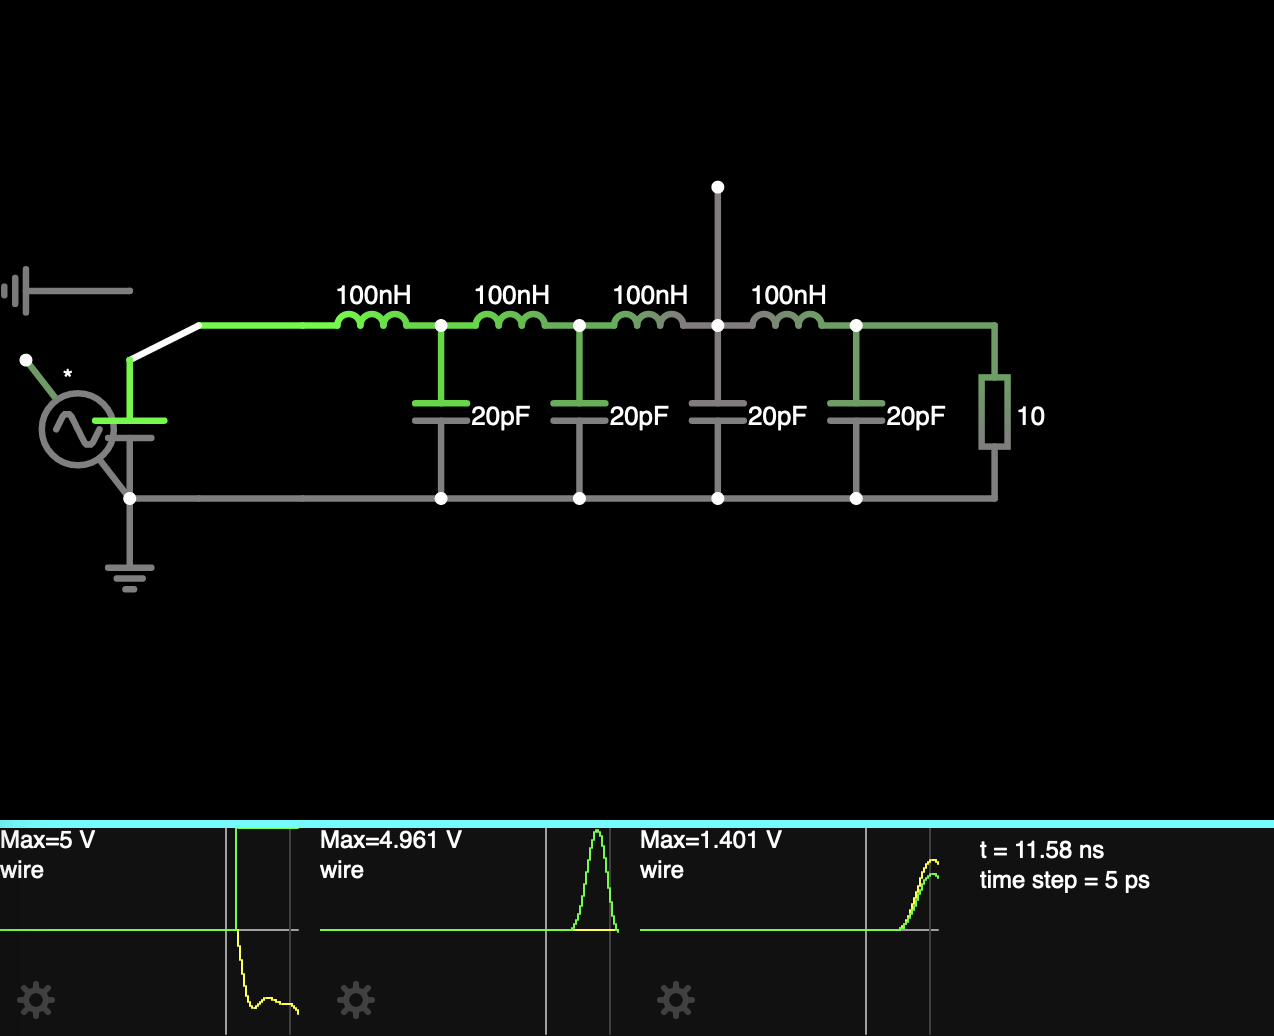

### Bonus unprepared topics if we've got lots of time left
- preequalisation 
- service flows
- a bit more explanation on interleaving
- 